## Testando Prompt (usando create_pandas_dataframe_agent)
Observações: aqui o prompt já é pre-made, portanto para alterar ele devo adicionar prefixo e/ou sufixo.

### Tokens e imports

In [7]:
# default
import os
from getpass import getpass
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

# langchain 
from langgraph.graph.message import add_messages
from langchain.agents import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description

from langchain_community.chat_models import ChatDeepInfra
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


from dotenv import load_dotenv
from pydantic import BaseModel


In [3]:
os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [5]:
os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

### Definindo Tools
Aqui definirei as tools do meu agente. Inicialmente tools simples e aleatórias apenas para testar

In [16]:
df = pd.read_csv("./datasets/pems03.csv")
print(f"DataFrame global carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

class SchemaTools(BaseModel):
    coluna: str

@tool()
def get_column_names() -> str:
    """
    Retorna uma lista com todos os nomes das colunas do dataset.
    Útil para saber quais colunas estão disponíveis para análise.

    Argumento: nenhum.
    Retorno: string.
    """
    global df 
    return str(df.columns.tolist())

@tool(args_schema=SchemaTools)
def summary_statistics(column_name: str) -> str:
    """
    Calcula estatísticas descritivas para uma coluna numérica específica.
    
    Argumento: nome da coluna .
    Retorna média, desvio padrão, mínimo, máximo e os quartis.
    """
    global df 
    return df[column_name].describe().to_string()

@tool(args_schema=SchemaTools)
def value_counts(column_name: str) -> str:
    """
    Conta a frequência de cada valor único em uma coluna categórica.
    Argumento: nome da coluna.
    Retorno: string.
    """
    global df 
    return df[column_name].value_counts().to_string()

@tool(args_schema=SchemaTools)
def check_missing_values(column_name: str) -> str:
    """
    Verifica e conta a quantidade de valores nulos (NaN) em uma coluna específica.
    Argumento: nome da coluna.
    Retorno: string.
    """
    global df 
    missing_count = df[column_name].isnull().sum()
    return f"A coluna '{column_name}' tem {missing_count} valores faltantes."

@tool(args_schema=SchemaTools)
def calculate_correlation(column_a: str, column_b: str) -> str:
    """
    Calcula a correlação entre duas colunas numéricas. O valor varia de -1 a 1.
    Argumento: nome da coluna 1, nome da coluna 2.
    Retorno: string.
    """
    global df 
    correlation = df[[column_a, column_b]].corr().iloc[0, 1]
    return f"A correlação entre '{column_a}' e '{column_b}' é: {correlation:.4f}"



DataFrame global carregado com 26208 linhas e 359 colunas.


In [ ]:
tools = [
    get_column_names,
    summary_statistics,
    value_counts,
    check_missing_values,
    calculate_correlation,
]

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)
agent = create_pandas_dataframe_agent(
    llm = llm,
    df= pd.DataFrame(df),
    verbose=True,
    allow_dangerous_code=True,
    return_intermediate_steps=True, # Retorna tb os pensamentos e ações do agente
    agent_type="zero-shot-react-description",
    extra_tools = tools,
    max_interations = 10,
    prefix = "Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário.",   # Comandos ou instruções específicas que definam claramente o papel do agente.
    sufix = "O nome do dataframe é df e ele representa uma série temporal."    # Instruções específicas que devem vir antes do início da pergunta do usuário.
)

c:\Users\gabri\Documents\agenteiadp\.venv\Lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:283: UserWarning: Received additional kwargs {'max_interations': 10, 'sufix': 'O nome do dataframe é df e ele representa uma série temporal.'} which are no longer supported.
  warnings.warn(


### Definições LangChain

In [23]:
class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list

graph_builder = StateGraph(State)

In [24]:
def chatbot(state: State):
    return {"messages": [agent.invoke(state["messages"])]}

# Nó de ferramentas
def tool_node(state: State):
    print("Nó de ferramentas chamado com estado:", state)
    return ToolNode(tools=tools)(state)

# Adicionando os nós simplificados
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

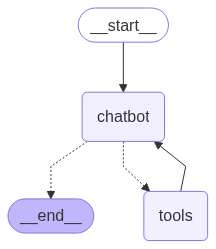

In [25]:
graph_builder.add_edge(START, "chatbot")

# As arestas condicionais e de volta para o chatbot
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")


checkpointer = MemorySaver()
config = {
    "configurable": {
        "model": llm,
        "thread_id": "1"
    }
}
graph = graph_builder.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estava focando. Estava tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"
Entretanto o próprio agent_dataframe ja faz essas coisas, então apenas usei o prefixo com a estratégia de persona, e o sufixo com informações do dataset.


### Tentando conversar com o agente

In [ ]:
estado = graph.invoke({"messages": [HumanMessage(content="Quais as colunas do dataset? Retorne seus nomes.")]}, config)



> Entering new AgentExecutor chain...
Thought: Para responder à pergunta, preciso primeiro entender a estrutura do dataset. Vou começar verificando as colunas presentes no dataset.

Action: python_repl_ast
Action Input: df.columnsIndex(['timestamp', '313344', '313349', '313438', '313450', '313487', '313493',
       '313512', '313551', '313552',
       ...
       '313144', '313159', '313166', '313172', '313178', '313184', '313190',
       '313197', '313204', '313339'],
      dtype='object', length=359)O dataset contém 359 colunas. Vou agora verificar os nomes das colunas para fornecer uma resposta mais detalhada.

Action: python_repl_ast
Action Input: list(df.columns)['timestamp', '313344', '313349', '313438', '313450', '313487', '313493', '313512', '313551', '313552', '317752', '313658', '317814', '317815', '317842', '317843', '317852', '317853', '315804', '317861', '317862', '313772', '317869', '315822', '317870', '315823', '315824', '315826', '315827', '315828', '315825', '315830',

TypeError: Type is not msgpack serializable: Index

In [49]:
estado["messages"]

[SystemMessage(content='\nVocê é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário, seguindo um ciclo rigoroso de raciocínio.\n\nVocê tem acesso às seguintes ferramentas:\n{tools}\n\n### REGRAS DE EXECUÇÃO\n1.  **Ciclo de Análise**: Você deve decompor o problema em passos. Para cada passo, você gerará um **Pensamento** e uma **Ação**. Sua resposta DEVE parar após o JSON da Ação.\n2.  **Análise da Observação**: Após sua ação, o sistema fornecerá uma **Observação**. Você DEVE analisar esta observação (seja um resultado ou um erro) para formular seu próximo Pensamento e Ação.\n3.  **Simplicidade das Ferramentas**: As ferramentas são simples. Elas NÃO aceitam filtros ou lógicas complexas no `action_input`. Se uma tarefa requer múltiplos passos (como filtrar por data e depois contar), você DEVE usar ferram